# Tweets Labeler

## Setup Snorkel Session and Load Data
Creates a snorkel session on SQLite database and loads tweets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

Exercise = candidate_subclass('Exercise', ['content'])

In [3]:
import pandas as pd
import ast
import re

docs = []
distinct_docs = []
json_file = 'data/tweets.json'

tweets = pd.read_json(json_file)
for t in tweets['tweet']:
    tweet = ast.literal_eval(t)
    #docs.append(tweet['text'])
    docs.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet['text']).split()))    

train_set = set()
dev_set = set()
test_set = set()

for i, doc in enumerate(docs):
    if doc not in distinct_docs:
        distinct_docs.append(doc)
        if i % 10 == 8:
            dev_set.add(doc)
        elif i % 10 == 9:
            test_set.add(doc)
        else:
            train_set.add(doc)    

In [5]:
from snorkel.candidates import CandidateExtractor
cand_extractor = CandidateExtractor(Exercise, [], [])

In [6]:
%%time
for i, docs in enumerate([train_set, dev_set, test_set]):    
    cand_extractor.apply(docs, split=i)
    print("Number of candidates:", session.query(Exercise).filter(Exercise.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 7756)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 965)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 964)
CPU times: user 2.61 s, sys: 244 ms, total: 2.85 s
Wall time: 3.22 s


In [7]:
# Load Gold Labels
from util import load_external_labels
%time missed = load_external_labels(session, Exercise, annotator_name='gold')

AnnotatorLabels created: 965
AnnotatorLabels created: 964
CPU times: user 24.4 s, sys: 100 ms, total: 24.5 s
Wall time: 25 s


In [8]:
# Load existing dev and test sets
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
print(L_gold_dev.shape, L_gold_test.shape)

((965, 1), (964, 1))


## Labeling Functions (LFs)
LF is a python function that accepts a tweet and returns 1 if it marks it as true, -1 if false, or 0 to abstain.

In [9]:
# Looks for a kb phrase in the tweet
#kb = 'data/kb.txt'
            
#def LF_distant_supervision(c):   
    #with open(kb) as f:
        #for phrase in f:
            #return 1 if c.find(phrase.strip()) >= 0 else -1    

In [10]:
# Use weak classifier
#import classifier

#def LF_weak_classifier(c):
    #return classify(c)

In [11]:
# Some random LF
import random

def LF_random_lf(c):
    return random.choice([-1, 0, 1])

In [12]:
# Another random LF
def LF_another_random_lf(c):
    return random.choice([-1, 0, 1])

In [13]:
print(LF_random_lf('a'), LF_another_random_lf('a'))

(0, 1)


In [15]:
# Group LFs in a list for later use
#LFs = [LF_distant_supervision, LF_weak_classifier, LF_random_lf, LF_another_random_lf]
LFs = [LF_random_lf, LF_another_random_lf]

In [16]:
# Check size of dev set labeled as exercise tweets using LF_random_lf
labeled = []
for c in session.query(Exercise).filter(Exercise.split == 1).all():
    if LF_random_lf(c) == 1:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 321)


In [17]:
# Evaluate the performance of LF_random_lf on dev set
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_random_lf, split=1, annotator_name='gold')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Instructions for updating:
Use the retry module or similar alternatives.
Scores (Un-adjusted)
Pos. class accuracy: 0.497
Neg. class accuracy: 0.518
Precision            0.265
Recall               0.497
F1                   0.346
----------------------------------------
TP: 79 | FP: 219 | TN: 235 | FN: 80



In [18]:
# Apply LFs
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [19]:
# Run labeler
import numpy as np
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6.63 s, sys: 48 ms, total: 6.68 s
Wall time: 6.81 s


<7756x2 sparse matrix of type '<type 'numpy.int64'>'
	with 10311 stored elements in Compressed Sparse Row format>

In [20]:
#  Load the labels as a sparse matrix
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 120 ms, sys: 4 ms, total: 124 ms
Wall time: 124 ms


<7756x2 sparse matrix of type '<type 'numpy.int64'>'
	with 10311 stored elements in Compressed Sparse Row format>

In [22]:
#  View statistics about the resulting label matrix
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_random_lf,0,0.666194,0.445591,0.222151
LF_another_random_lf,1,0.663228,0.445591,0.222151


## The Generative Model

Train a model of the LFs to estimate their accuracies and then combine the outputs of the LFs into a noise-aware training labels set.

In [23]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [24]:
gen_model.weights.lf_accuracy

array([ 0.55207343,  0.55443033])

In [25]:
# Apply gen model to the training candidates to get the noise-aware training label set (training marginals)
train_marginals = gen_model.marginals(L_train)

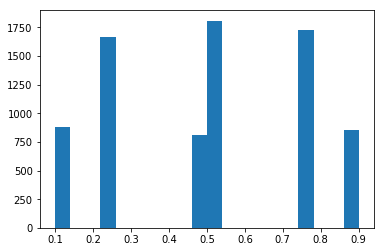

In [26]:
# Distribution of the training marginals
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [27]:
# Learned accuracy parameters, and other statistics about the LFs learned by the generative model
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.739087,0.7033,0.741007,0.518839
1,0.749207,0.6938,0.746427,0.526093


### Iterate on Labeling Functions
Improve the LF set.  First, we apply the LFs to our development set:

In [28]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [29]:
# Get the score of the generative model
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.447
Neg. class accuracy: 0.586
Precision            0.279
Recall               0.447
F1                   0.344
----------------------------------------
TP: 114 | FP: 294 | TN: 416 | FN: 141



In [30]:
# Explore some of the additional functionalities of the lf_stats method for the dev set
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_random_lf,0,0.654922,0.435233,0.201036,68,224,96,244,0.493671,0.749426
LF_another_random_lf,1,0.652850,0.435233,0.201036,94,209,70,257,0.557143,0.748274


### Save the training labels

Save the `training_marginals` (**probabilistic training labels**) for later use to train an end extraction model:

In [31]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 7756 marginals
CPU times: user 3.96 s, sys: 40 ms, total: 4 s
Wall time: 4.12 s
